## ECE 230B: Lab 3



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import commpy.filters as filters
from commpy.modulation import QAMModem
from ece230b import *

In [2]:
pluto_token = None
# pluto_token = '7d1-EddvbnU' # 1:30-2:00am
# pluto_token = 'NS8uqBzWDLU' # 2:00-2:30am
# pluto_token = 'uJ_6FnhzugM' # 2:30-3:00am


### Part I: The Transmitter

Begin by generating `N=1000` random `M`-QAM symbols, drawn uniformly from a constellation with unit average energy per symbol, `E_s=1`. Let's start with 64-QAM. Optionally, insert `N/10` zeros before or after your sequence of symbols. This will make it a bit easier to recognize your signal in the time domain. Then, perform pulse shaping at the transmitter using a root raised cosine (RRC) filter at a symbol rate of `1/T=10^5` symbols per second, meaning symbols are sent every 10 microseconds. Use a sampling rate of 1MSPS, and thus the number of samples should be 10. Use a rolloff factor of `beta=0.5`. Use a cyclic transmit buffer, and set the transmit gain to `-25dB`. **Plot** the real and imaginary parts of the transmit signal, zooming in so your pulse-shaped symbols can be observed clearly. Transmit this pulse-shaped waveform from the Pluto at a carrier frequency of your choice between 905-925 MHz using `sdr.tx()`. 

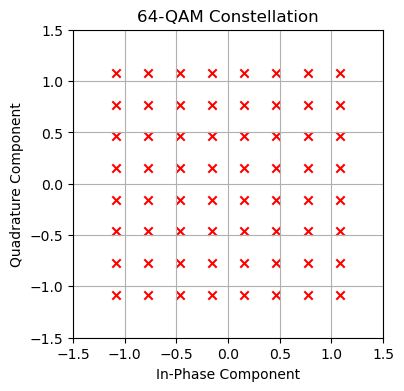

In [3]:
# Generate 1000 random 64-QAM symbols
N=1000
M=64
symbols, constellation = gen_rand_qam_symbols(N, M)
# Insert zeros at beginning of symbols 
# zeros_symbols = np.concatenate((np.zeros(int(N/10), dtype=complex), symbols))
zeros_symbols = symbols

# Visualize constellation
%matplotlib inline
plt.figure(figsize=(4, 4))
plt.scatter(constellation.real, constellation.imag, c='red', marker='x')
plt.title(f"{M}-QAM Constellation")
plt.xlabel("In-Phase Component")
plt.ylabel("Quadrature Component")
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

norm of g_tx: 1.0


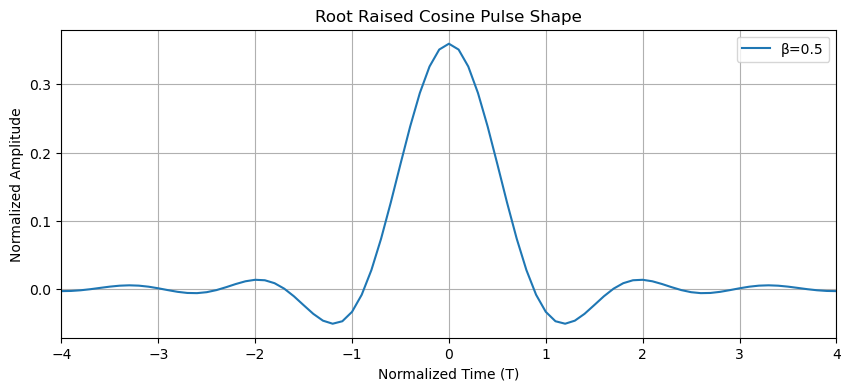

In [4]:
# Perform pulse shaping with RRC filter
span = 8 # Number of symbols to span
sps = 10 # Samples per symbol
beta = 0.5 # Roll-off factor

t_filter, g_tx = get_rrc_pulse(beta, span, sps) # normalalized to unit norm
print(f"norm of g_tx: {np.sum(np.abs(g_tx)**2)}")  # Check energy of the pulse
# t_filter, g_tx = filters.rrcosfilter(span*sps, beta, 1, sps)

# Visualize pulse shape
plt.figure(figsize=(10, 4))
plt.plot(t_filter, g_tx, label=f'β={beta}')
plt.title("Root Raised Cosine Pulse Shape")
plt.xlabel("Normalized Time (T)")
plt.ylabel("Normalized Amplitude")
plt.xlim(-span/2, span/2)
plt.grid(True)
plt.legend()
plt.show()

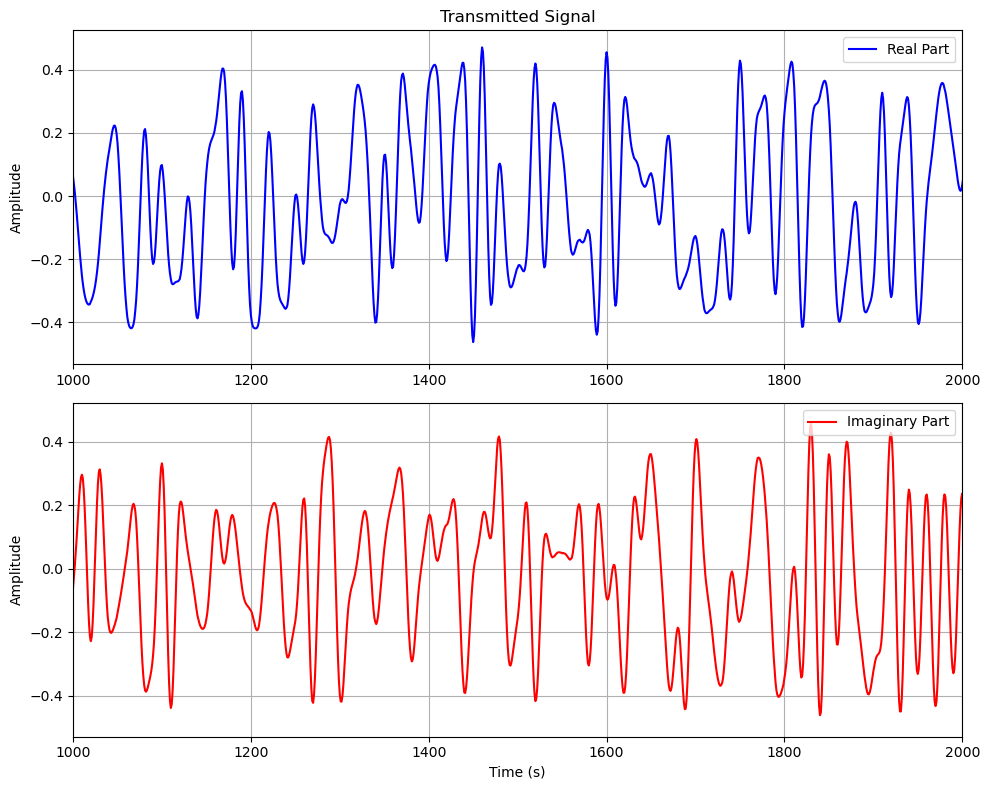

In [5]:
t, pulse_train = create_pulse_train(zeros_symbols, sps)

tx_signal = np.convolve(g_tx, pulse_train, mode='same')

# Visualize tx signal
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title("Transmitted Signal")
plt.plot(t, np.real(tx_signal), label='Real Part', color='blue')
plt.xlim(N/10*sps, 2*N/10*sps)
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc='upper right')
plt.subplot(2, 1, 2)
plt.plot(t, np.imag(tx_signal), label='Imaginary Part', color='red')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.xlim(N/10*sps, 2*N/10*sps)
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [6]:
# Pluto SDR Setup - Transmitter
from remoteRF.drivers.adalm_pluto import *

# ---------------------------------------------------------------
# Digital communication system parameters.
# ---------------------------------------------------------------
fs = 1e6     # baseband sampling rate (samples per second)
ts = 1 / fs  # baseband sampling period (seconds per sample)
sps = 10     # samples per data symbol
T = ts * sps # time between data symbols (seconds per symbol)

if pluto_token is not None: 
# ---------------------------------------------------------------
# Pluto system parameters.
# ---------------------------------------------------------------
    sample_rate = fs                # sampling rate, between ~600e3 and 61e6
    tx_carrier_freq_Hz = 915e6      # transmit carrier frequency, between 325 MHz to 3.8 GHz
    tx_rf_bw_Hz = sample_rate * 1   # transmitter's RF bandwidth, between 200 kHz and 56 MHz
    tx_gain_dB = -25                # transmit gain (in dB), beteween -89.75 to 0 dB with a resolution of 0.25 dB
    tx_cyclic_buffer = True         # cyclic nature of transmitter's buffer (True -> continuously repeat transmission)

# ---------------------------------------------------------------
# Initialize Pluto object using issued token.
# ---------------------------------------------------------------
    sdr = adi.Pluto(token=pluto_token) # create Pluto object
    sdr.sample_rate = int(sample_rate)   # set baseband sampling rate of Pluto

# ---------------------------------------------------------------
# Setup Pluto's transmitter.
# ---------------------------------------------------------------
    sdr.tx_destroy_buffer()                   # reset transmit data buffer to be safe
    sdr.tx_rf_bandwidth = int(tx_rf_bw_Hz)    # set transmitter RF bandwidth
    sdr.tx_lo = int(tx_carrier_freq_Hz)       # set carrier frequency for transmission
    sdr.tx_hardwaregain_chan0 = tx_gain_dB    # set the transmit gain
    sdr.tx_cyclic_buffer = tx_cyclic_buffer   # set the cyclic nature of the transmit buffer

In [7]:
# Pluto SDR Setup
from remoteRF.drivers.adalm_pluto import *
# ---------------------------------------------------------------
# Digital communication system parameters.
# ---------------------------------------------------------------
fs = 1e6     # baseband sampling rate (samples per second)
ts = 1 / fs  # baseband sampling period (seconds per sample)
sps = 10     # samples per data symbol
T = ts * sps # time between data symbols (seconds per symbol)

# ---------------------------------------------------------------
# Pluto system parameters.
# ---------------------------------------------------------------
sample_rate = fs                # sampling rate, between ~600e3 and 61e6
tx_carrier_freq_Hz = 915e6      # transmit carrier frequency, between 325 MHz to 3.8 GHz
rx_carrier_freq_Hz = 915e6      # receive carrier frequency, between 325 MHz to 3.8 GHz
tx_rf_bw_Hz = sample_rate * 1   # transmitter's RF bandwidth, between 200 kHz and 56 MHz
rx_rf_bw_Hz = sample_rate * 1   # receiver's RF bandwidth, between 200 kHz and 56 MHz
tx_gain_dB = -20                # transmit gain (in dB), beteween -89.75 to 0 dB with a resolution of 0.25 dB
rx_gain_dB = 40                 # receive gain (in dB), beteween 0 to 74.5 dB (only set if AGC is 'manual')
rx_agc_mode = 'manual'          # receiver's AGC mode: 'manual', 'slow_attack', or 'fast_attack'
rx_buffer_size = 500e3          # receiver's buffer size (in samples), length of data returned by sdr.rx()
tx_cyclic_buffer = True         # cyclic nature of transmitter's buffer (True -> continuously repeat transmission)

# ---------------------------------------------------------------
# Initialize Pluto object using issued token.
# ---------------------------------------------------------------
if pluto_token is not None:
    sdr = adi.Pluto(token=pluto_token) # create Pluto object
    sdr.sample_rate = int(sample_rate)   # set baseband sampling rate of Pluto

# ---------------------------------------------------------------
# Setup Pluto's transmitter.
# ---------------------------------------------------------------
    sdr.tx_destroy_buffer()                   # reset transmit data buffer to be safe
    sdr.tx_rf_bandwidth = int(tx_rf_bw_Hz)    # set transmitter RF bandwidth
    sdr.tx_lo = int(tx_carrier_freq_Hz)       # set carrier frequency for transmission
    sdr.tx_hardwaregain_chan0 = tx_gain_dB    # set the transmit gain
    sdr.tx_cyclic_buffer = tx_cyclic_buffer   # set the cyclic nature of the transmit buffer

# ---------------------------------------------------------------
# Setup Pluto's receiver.
# ---------------------------------------------------------------
    sdr.rx_destroy_buffer()                   # reset receive data buffer to be safe
    sdr.rx_lo = int(rx_carrier_freq_Hz)       # set carrier frequency for reception
    sdr.rx_rf_bandwidth = int(sample_rate)    # set receiver RF bandwidth
    sdr.rx_buffer_size = int(rx_buffer_size)  # set buffer size of receiver
    sdr.gain_control_mode_chan0 = rx_agc_mode # set gain control mode
    sdr.rx_hardwaregain_chan0 = rx_gain_dB    # set gain of receiver

### Part II: The Receiver

Set the receiver's carrier frequency to that matching the transmitter. Set the receiver's gain control to `"manual"`, and use a gain of 40 dB. Set the receive buffer size to `500*10^3` samples. Take a receive capture with the Pluto using `sdr.rx()`. **Plot** the real and imaginary parts of the received signal, zooming in so the received pulse-shaped waveform can be observed closely. 

In [8]:
# Pluto SDR Setup - Receiver

if pluto_token is not None:
# ---------------------------------------------------------------
# Pluto system parameters.
# ---------------------------------------------------------------
    rx_carrier_freq_Hz = 915e6      # receive carrier frequency, between 325 MHz to 3.8 GHz
    rx_rf_bw_Hz = sample_rate * 1   # receiver's RF bandwidth, between 200 kHz and 56 MHz
    rx_gain_dB = 40                 # receive gain (in dB), beteween 0 to 74.5 dB (only set if AGC is 'manual')
    rx_agc_mode = 'manual'          # receiver's AGC mode: 'manual', 'slow_attack', or 'fast_attack'
    rx_buffer_size = 500e3          # receiver's buffer size (in samples), length of data returned by sdr.rx()

# ---------------------------------------------------------------
# Setup Pluto's receiver.
# ---------------------------------------------------------------
    sdr.rx_lo = int(rx_carrier_freq_Hz)       # set carrier frequency for reception
    sdr.rx_rf_bandwidth = int(sample_rate)    # set receiver RF bandwidth
    sdr.rx_buffer_size = int(rx_buffer_size)  # set buffer size of receiver
    sdr.gain_control_mode_chan0 = rx_agc_mode # set gain control mode
    sdr.rx_hardwaregain_chan0 = rx_gain_dB    # set gain of receiver

No Pluto token provided, simulating transmission and reception.


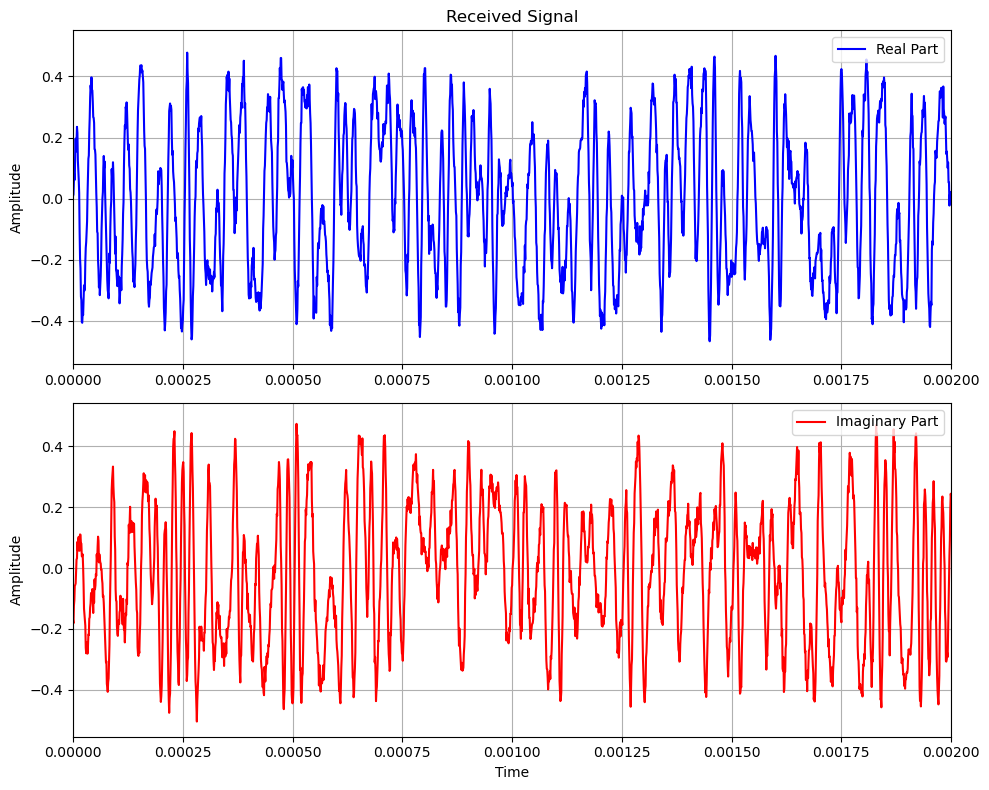

In [9]:
# Transmit and receive the signal

if pluto_token is not None: 
    # Transmit signal
    tx_scaled = tx_signal / np.max(np.abs(tx_signal)) * 2**14 # Pluto expects TX samples to be between -2^14 and 2^14
    sdr.tx(tx_scaled)

    # Receive signal
    sdr.rx_destroy_buffer()
    rx_signal = sdr.rx() / np.max(np.abs(sdr.rx()))

    t = np.arange(rx_buffer_size) / sample_rate  # time vector for TX signal

else: 
    print("No Pluto token provided, simulating transmission and reception.")
    N0 = 0.001
    noise = np.sqrt(N0/2) * (np.random.randn(len(tx_signal)) + 1j * np.random.randn(len(tx_signal)))  # complex noise
    rx_signal = tx_signal + noise

    t = np.arange(len(zeros_symbols) * sps) / sample_rate  # time vector for TX signal

# Visualize received signal
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title("Received Signal")
plt.plot(t, np.real(rx_signal), label='Real Part', color='blue')
plt.ylabel("Amplitude")
plt.xlim(0, t[int(2*N/10*sps)])
plt.grid(True)
plt.legend(loc='upper right')
plt.subplot(2, 1, 2)
plt.plot(t, np.imag(rx_signal), label='Imaginary Part', color='red')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.xlim(0, t[int(2*N/10*sps)])
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Part III: Matched Filter

Pass the received signal through a filter matched to the transmitter's pulse shape. **Plot** the impulse response of the *effective* pulse shape to confirm it indeed satisfies the Nyquist ISI criterion. **Plot** the real and imaginary parts of the matched filter output. 

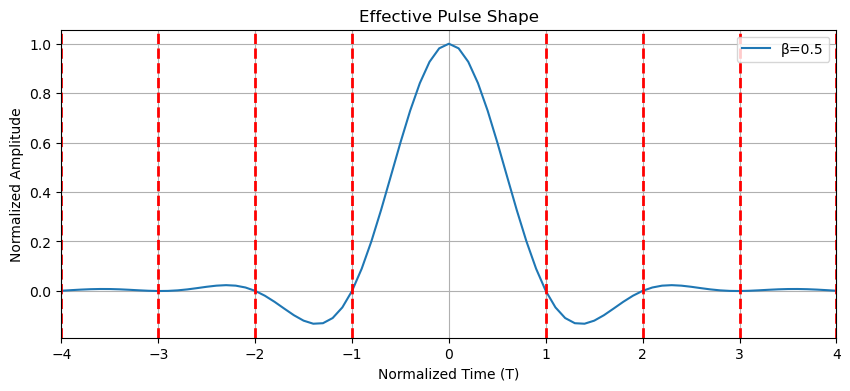

In [10]:
# Generate receiver matched filter
g_rx = np.conj(g_tx[::-1])

# Visualize effective pulse shape
effective_pulse = np.convolve(g_tx, g_rx, mode='same')
plt.figure(figsize=(10, 4))
plt.plot(t_filter, effective_pulse, label=f'β={beta}')
for k in range(int(np.ceil(t_filter[0])), int(np.floor(t_filter[-1])) + 1):
    if k != 0: plt.axvline(k, color='red', lw=2, ls='--')
plt.title("Effective Pulse Shape")
plt.xlabel("Normalized Time (T)")
plt.ylabel("Normalized Amplitude")
plt.xlim(-span/2, span/2)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

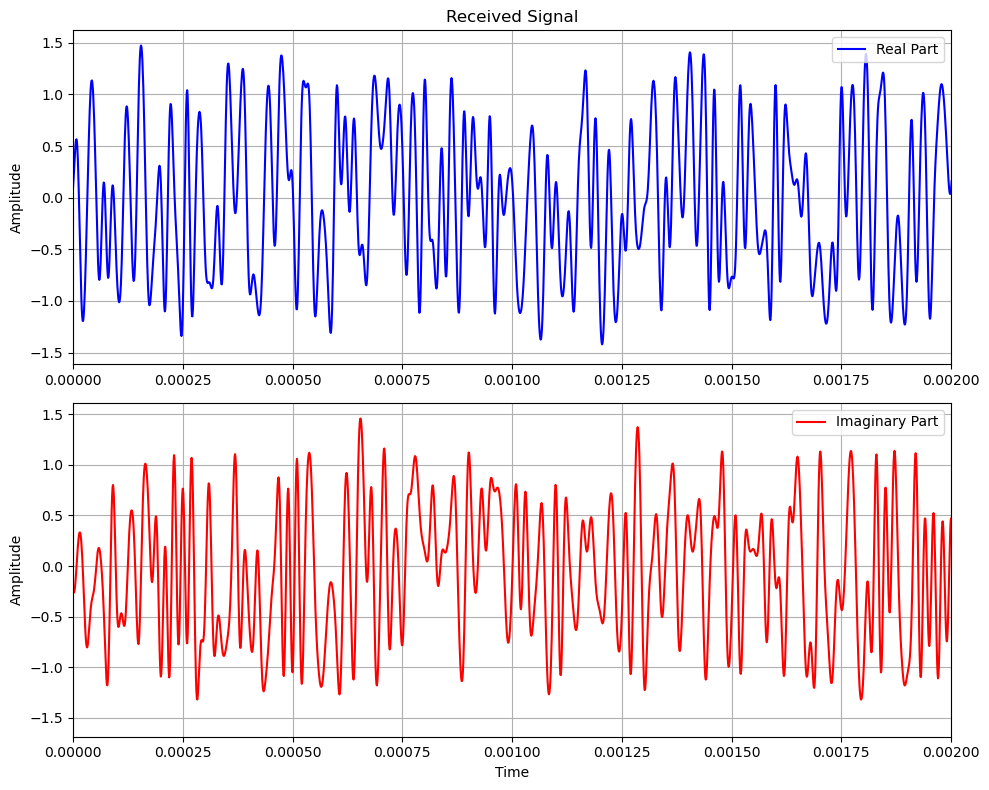

In [11]:
# Pass received signal through matched filter
rx_signal_mf = np.convolve(rx_signal, g_rx, mode='same')

# Visualize matched filter output
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title("Received Signal")
plt.plot(t, np.real(rx_signal_mf), label='Real Part', color='blue')
plt.ylabel("Amplitude")
plt.xlim(0, t[int(2*N/10*sps)])
plt.grid(True)
plt.legend(loc='upper right')
plt.subplot(2, 1, 2)
plt.plot(t, np.imag(rx_signal_mf), label='Imaginary Part', color='red')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.xlim(0, t[int(2*N/10*sps)])
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

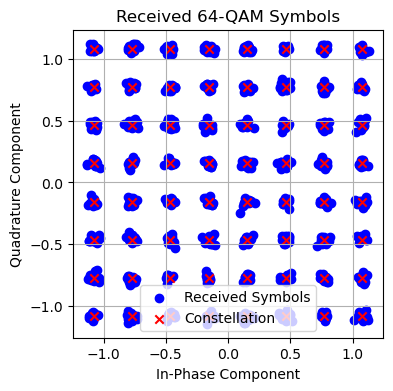

In [12]:
# visualize received symbols
rx_symbols = rx_signal_mf[::sps]  # Extract symbols from matched filter output

plt.figure(figsize=(4, 4))
plt.scatter(np.real(rx_symbols), np.imag(rx_symbols), c='blue', marker='o', label='Received Symbols')
plt.scatter(constellation.real, constellation.imag, c='red', marker='x', label='Constellation')
plt.title("Received 64-QAM Symbols")
plt.xlabel("In-Phase Component")
plt.ylabel("Quadrature Component")
plt.grid(True)
plt.legend()
plt.show()

### Part IV: Frame Synchronization

You'll notice your received signal is not perfectly time-aligned with the transmit signal. In other words, the received copy of the transmit signal has some time offset that needs to be accounted for at the receiver. Correcting for this offset is the problem of timing synchronization, as discussed in class. You’ll also notice that you have received multiple copies of your transmitted signal, due to the size of your receive buffer relative to the length of the signal (which was cyclically transmitted). We only want to extract one copy of the transmitted signal. Prepend to your transmitted symbols a Zadoff-Chu sequence to help us locate the transmitted signal. Assume that this sequence is known to the receiver. Given our received signal is upsampled by a factor of 10 samples per symbol, the receiver can either correlate with the Zadoff-Chu symbols (one out of every ten samples) or correlate with a pulse-shaped version of those symbols. Perform frame synchronization using one (or both) of these methods and extract a single copy of the transmitted signal. **Plot** the magnitude of the cross-correlation output during frame synchronization.

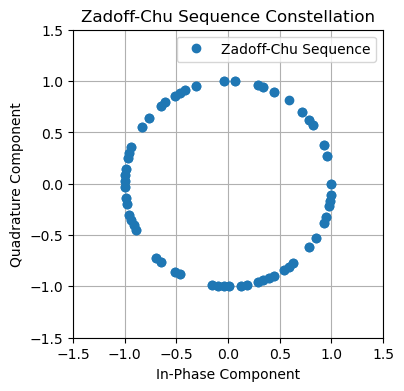

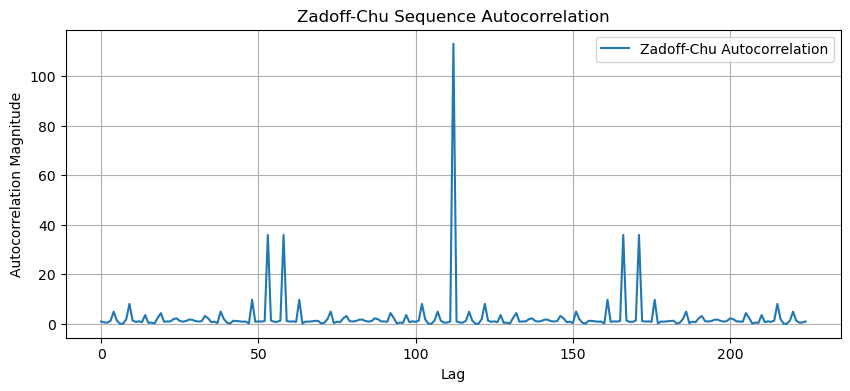

In [13]:
# Generate Zadoff-Chu sequence
N_zc = 113 # Length of Zadoff-Chu sequence
zc_sequence = gen_zadoff_chu_sequence(N_zc, 23)

# Visualize Zadoff-Chu sequence
plt.figure(figsize=(4, 4))
plt.plot(np.real(zc_sequence), np.imag(zc_sequence), 'o', label='Zadoff-Chu Sequence')
plt.title("Zadoff-Chu Sequence Constellation")
plt.xlabel("In-Phase Component")
plt.ylabel("Quadrature Component")
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.show()

# Visualize Zadoff-Chu autocorrelation
plt.figure(figsize=(10, 4))
plt.plot(np.abs(np.correlate(zc_sequence, zc_sequence, mode='full')), label='Zadoff-Chu Autocorrelation')
plt.title("Zadoff-Chu Sequence Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation Magnitude")
plt.grid(True)
plt.legend()
plt.show()

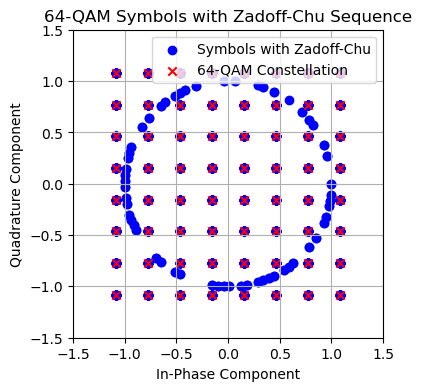

In [14]:
# Generate TX signal with Zadoff-Chu sequence

symbols_zc = np.concatenate((zc_sequence, symbols))

# Visualize symbols with Zadoff-Chu sequence
plt.figure(figsize=(4, 4))
plt.scatter(np.real(symbols_zc), np.imag(symbols_zc), c='blue', marker='o', label='Symbols with Zadoff-Chu')
plt.scatter(constellation.real, constellation.imag, c='red', marker='x', label='64-QAM Constellation')
plt.title("64-QAM Symbols with Zadoff-Chu Sequence")
plt.xlabel("In-Phase Component")
plt.ylabel("Quadrature Component")
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.show()

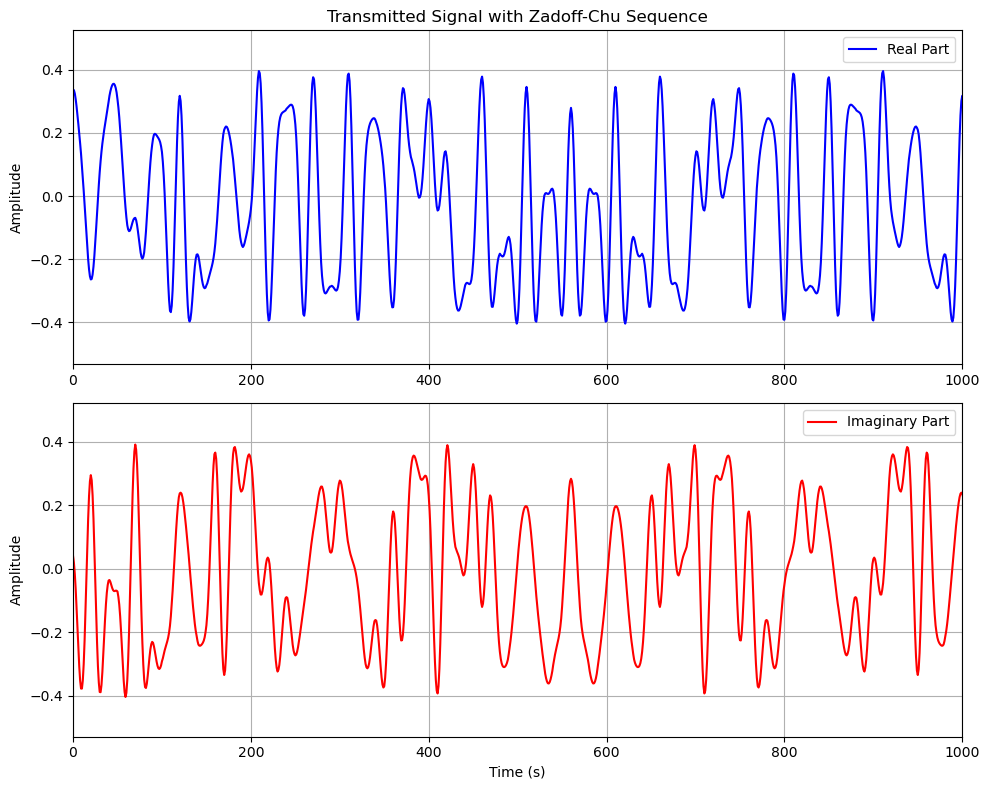

In [ ]:
# Pulse shape the Zadoff-Chu sequence
t, pulse_train_zc = create_pulse_train(symbols_zc, sps)
tx_signal_zc = np.convolve(g_tx, pulse_train_zc, mode='same')

# Visualize pulse-shaped TX signal
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title("Transmitted Signal with Zadoff-Chu Sequence")
plt.plot(t, np.real(tx_signal_zc), label='Real Part', color='blue')
plt.xlim(0, N/10*sps)
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc='upper right')
plt.subplot(2, 1, 2)
plt.plot(t, np.imag(tx_signal_zc), label='Imaginary Part', color='red')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.xlim(0, N/10*sps)
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

No Pluto token provided, simulating transmission and reception.


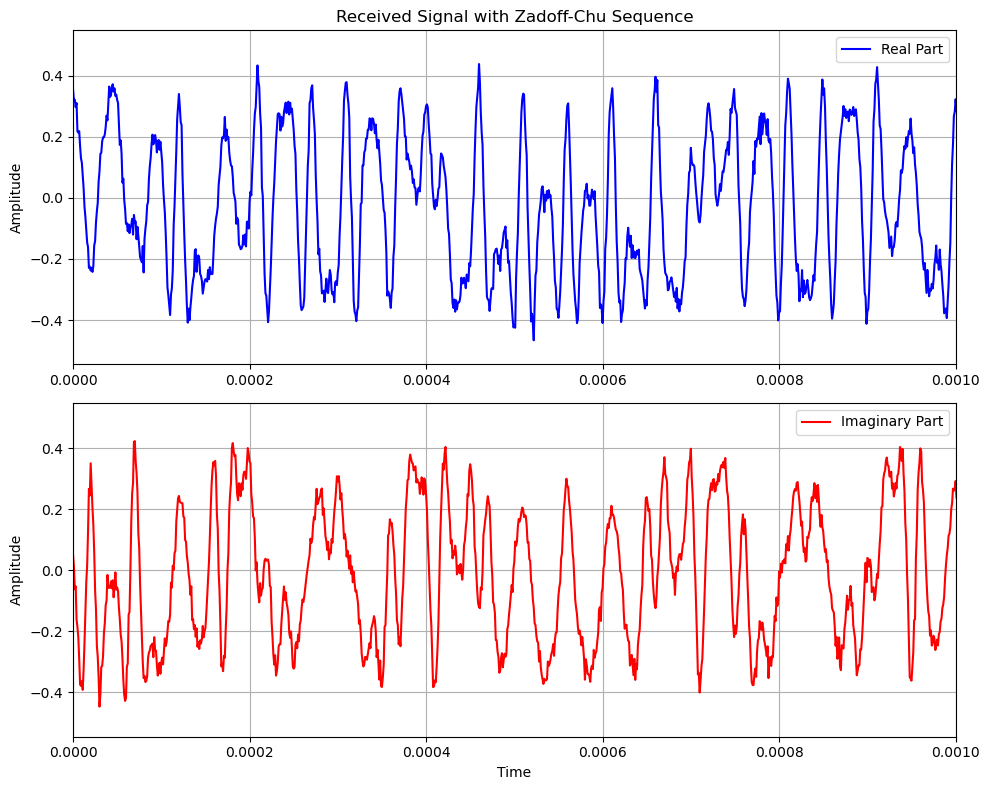

In [16]:
# Transmit and receive the signal 
# pluto_token = None
if pluto_token is not None: 
    # Transmit signal
    tx_scaled_zc = tx_signal_zc / np.max(np.abs(tx_signal_zc)) * 2**14 # Pluto expects TX samples to be between -2^14 and 2^14
    sdr.tx(tx_scaled_zc)

    # Receive signal
    sdr.rx_destroy_buffer()
    rx_signal_zc = sdr.rx() / np.max(np.abs(sdr.rx()))  # Normalize received signal

    
    t = np.arange(rx_buffer_size) / sample_rate  # time vector for TX signal

else: 
    print("No Pluto token provided, simulating transmission and reception.")
    N0 = 0.001
    noise = np.sqrt(N0/2) * (np.random.randn(len(tx_signal_zc)) + 1j * np.random.randn(len(tx_signal_zc)))  # complex noise
    rx_signal_zc = tx_signal_zc + noise
    t = np.arange(len(symbols_zc) * sps) / sample_rate  # time vector for TX signal

# Visualize received signal
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title("Received Signal with Zadoff-Chu Sequence")
plt.plot(t, np.real(rx_signal_zc), label='Real Part', color='blue')
plt.ylabel("Amplitude")
plt.xlim(0, t[int(N/10*sps)])
plt.grid(True)
plt.legend(loc='upper right')
plt.subplot(2, 1, 2)
plt.plot(t, np.imag(rx_signal_zc), label='Imaginary Part', color='red')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.xlim(0, t[int(N/10*sps)])
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

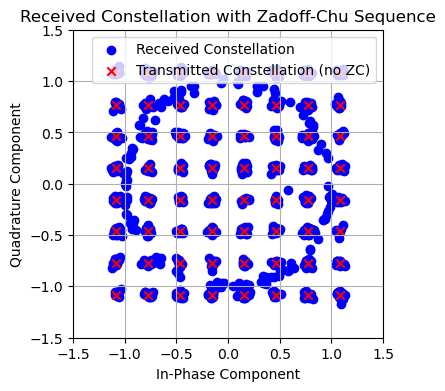

In [17]:
# Pass received signal through matched filter
rx_signal_mf_zc = np.convolve(rx_signal_zc, g_rx, mode='same')

plt.figure(figsize=(4,4))
plt.scatter(np.real(rx_signal_mf_zc[::sps]), np.imag(rx_signal_mf_zc[::sps]), c='blue', marker='o', label='Received Constellation')
plt.scatter(constellation.real, constellation.imag, c='red', marker='x', label='Transmitted Constellation (no ZC)')
plt.title("Received Constellation with Zadoff-Chu Sequence")
plt.xlabel("In-Phase Component")
plt.ylabel("Quadrature Component")
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.show()

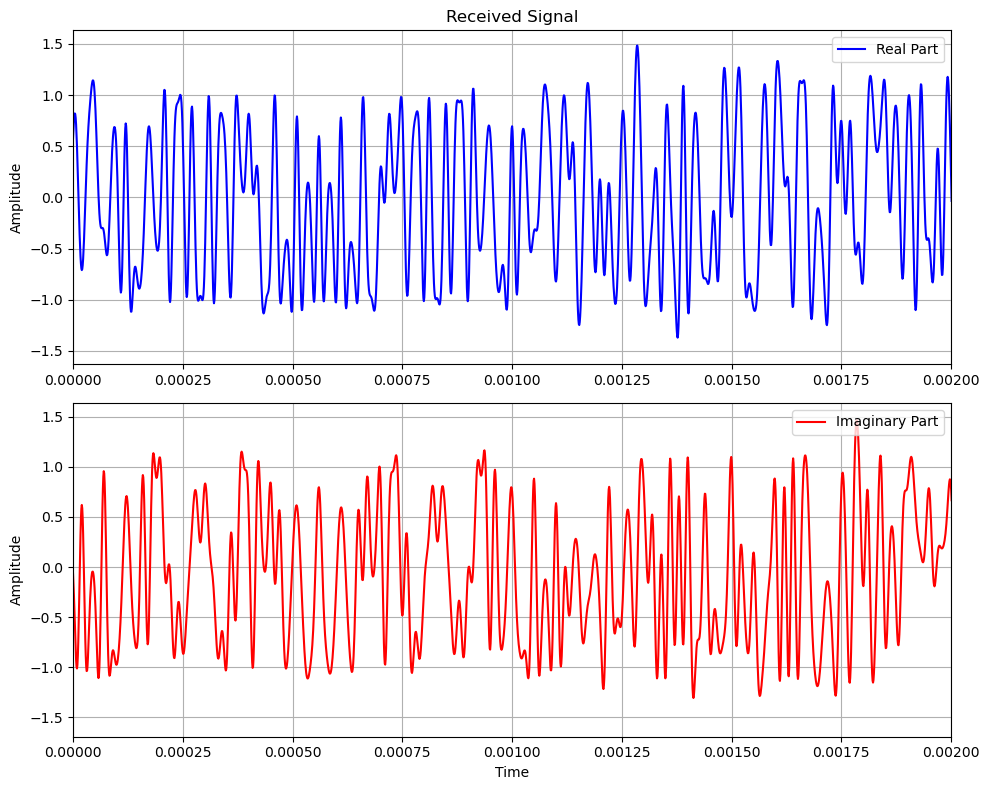

In [22]:
# Visualize matched filter output
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title("Received Signal")
plt.plot(t, np.real(rx_signal_mf_zc), label='Real Part', color='blue')
plt.ylabel("Amplitude")
plt.xlim(0, t[int(2*N/10*sps)])
plt.grid(True)
plt.legend(loc='upper right')
plt.subplot(2, 1, 2)
plt.plot(t, np.imag(rx_signal_mf_zc), label='Imaginary Part', color='red')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.xlim(0, t[int(2*N/10*sps)])
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

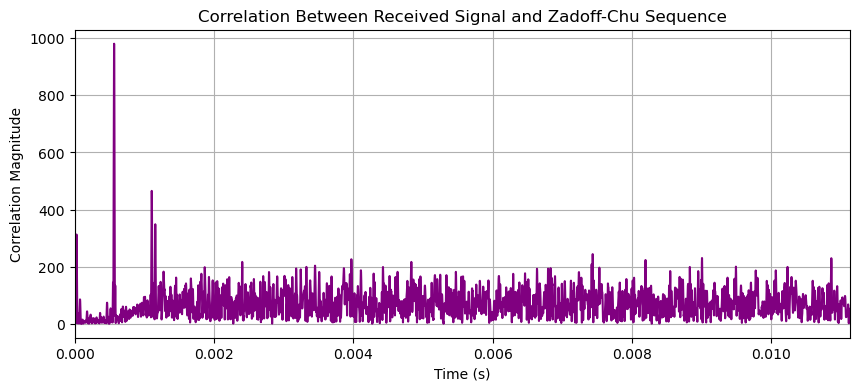

In [23]:
# Correlate received signal with pulse-shaped Zadoff-Chu sequence 
_, zc_sequence_pulse = create_pulse_train(zc_sequence, sps)
zc_sequence_shaped = np.convolve(np.convolve(g_tx, zc_sequence_pulse, mode='same'), g_rx, mode='same')
correlation = np.correlate(rx_signal_mf_zc, zc_sequence_shaped, mode='same')

# Visualize correlation result
plt.figure(figsize=(10, 4))
plt.plot(t, np.abs(correlation), label='Correlation with Zadoff-Chu Sequence', color='purple')
plt.title("Correlation Between Received Signal and Zadoff-Chu Sequence")
plt.xlabel("Time (s)")
plt.ylabel("Correlation Magnitude")
plt.xlim(0, t[np.min([len(t), int(2*N*sps)])-1])
plt.grid(True)
plt.show()

[565]


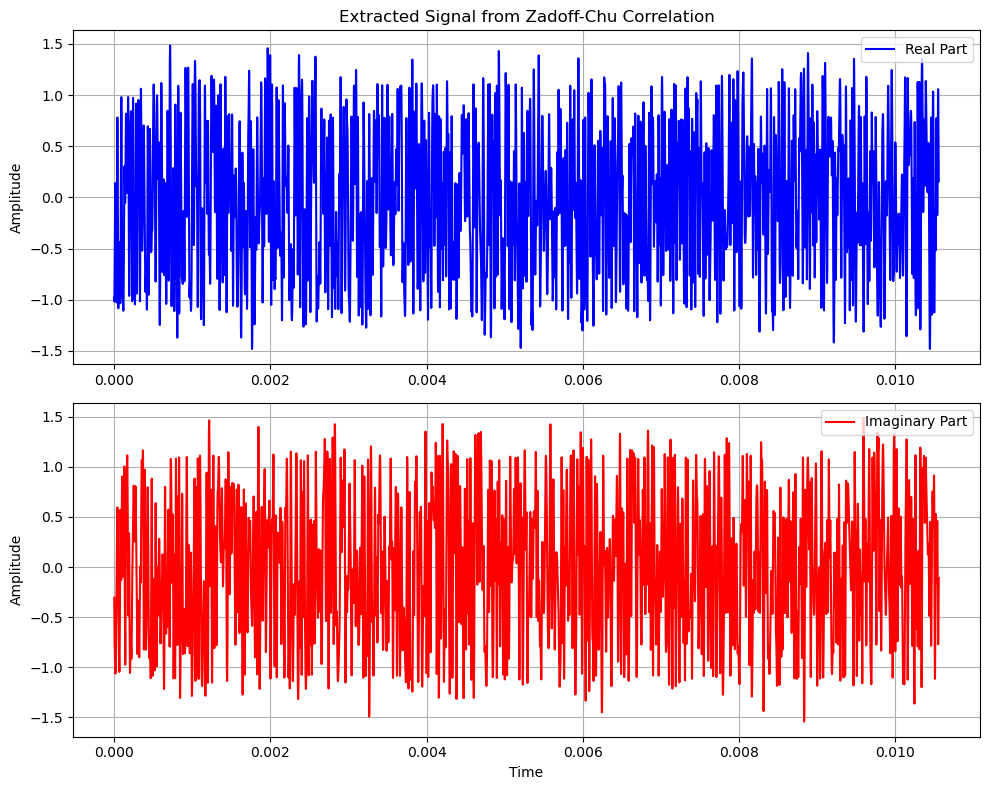

In [25]:
# Extract one copy of TX signal between correlation peaks
corr_peaks, _ = signal.find_peaks(np.abs(correlation), height=np.max(np.abs(correlation)) * 0.99)
if len(corr_peaks) < 2:  # take till end of rx_signal
    rx_signal_zc_extracted = rx_signal_mf_zc[corr_peaks[0]+5:]
else: 
    rx_signal_zc_extracted = rx_signal_mf_zc[corr_peaks[0]+5:corr_peaks[1]]
print(corr_peaks)

# Visualize extracted signal
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title("Extracted Signal from Zadoff-Chu Correlation")
plt.plot(t[:len(rx_signal_zc_extracted)], np.real(rx_signal_zc_extracted), label='Real Part', color='blue')
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc='upper right')
plt.subplot(2, 1, 2)
plt.plot(t[:len(rx_signal_zc_extracted)], np.imag(rx_signal_zc_extracted), label='Imaginary Part', color='red')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


### Part V: Channel Equalization and Symbol Detection

Sample the extracted portion of the received signal from Part IV every `T` seconds to get your received symbols. If everything has gone according to plan, these received symbols contain the transmitted symbols plus AWGN, with little to no ISI. The channel across our narrowband transmission is approximately frequency-flat and thus causes a scaling and rotation of our transmitted symbols. **Plot** the real and imaginary components of each received symbol on the complex plane, and then overlay the originally transmitted symbols. You should be able to observe the effects of the channel.

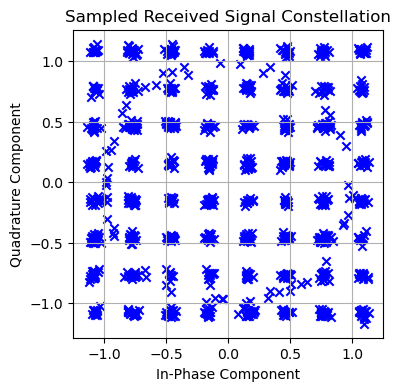

In [27]:
# Sample the extracted signal at symbol rate

rx_signal_zc_sampled = rx_signal_zc_extracted[::sps]

# Visualize sampled signal
plt.figure(figsize=(4, 4))
plt.scatter(np.real(rx_signal_zc_sampled), np.imag(rx_signal_zc_sampled), c='blue', marker='x')
plt.title("Sampled Received Signal Constellation")
plt.xlabel("In-Phase Component")
plt.ylabel("Quadrature Component")
plt.grid(True)
plt.show()
